<a href="https://colab.research.google.com/github/bhavanasreeps18/Indian_classical_music_generation_using_LSTM_and_RNN/blob/main/music_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
!pip install glob2


In [74]:
import glob2

In [75]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from music21 import converter, instrument, note, chord
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from music21 import stream

In [76]:
# Load and preprocess MIDI data
def get_notes():
    notes = []
    for file in glob2.glob("indian_classical_music/*.mid"):
        try:
            print("Parsing MIDI file:", file)
            midi = converter.parse(file)
            notes_to_parse = None
            parts = instrument.partitionByInstrument(midi)
            if parts:
                notes_to_parse = parts.parts[0].recurse()
            else:
                notes_to_parse = midi.flat.notes
            for element in notes_to_parse:
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                elif isinstance(element, chord.Chord):
                    notes.append('.'.join(str(n) for n in element.normalOrder))
        except Exception as e:
            print("Error parsing MIDI file:", file)
            print("Exception:", e)
    return notes


In [77]:
# Prepare sequences for training
def prepare_sequences(notes, sequence_length):
    sequence_input = []
    sequence_output = []
    pitch_names = sorted(set(notes))
    note_to_int = dict((note, number) for number, note in enumerate(pitch_names))
    for i in range(0, len(notes) - sequence_length, 1):
        input_sequence = notes[i:i + sequence_length]
        output_sequence = notes[i + sequence_length]
        sequence_input.append([note_to_int[char] for char in input_sequence])
        sequence_output.append(note_to_int[output_sequence])
    n_patterns = len(sequence_input)
    sequence_input = np.reshape(sequence_input, (n_patterns, sequence_length, 1))
    sequence_input = sequence_input / float(len(pitch_names))
    sequence_output = tf.keras.utils.to_categorical(sequence_output)
    return sequence_input, sequence_output


In [78]:
# Define LSTM model
def create_model(input_shape, output_shape):
    model = Sequential()
    model.add(LSTM(256, input_shape=input_shape, return_sequences=True))
    model.add(LSTM(256))
    model.add(Dense(output_shape, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    return model


In [79]:
# Train the model
def train_model(model, sequence_input, sequence_output, epochs=1, batch_size=64):
    model.fit(sequence_input, sequence_output, epochs=epochs, batch_size=batch_size)


In [80]:
# Generate music using the trained model
def generate_music(model, pitch_names, sequence_length, seed_notes, num_notes):
    int_to_note = dict((number, note) for number, note in enumerate(pitch_names))
    pattern = seed_notes.tolist()  # Convert NumPy array to list
    generated_notes = []
    for i in range(num_notes):
        prediction_input = np.reshape(pattern, (1, len(pattern), 1))
        prediction_input = prediction_input / float(len(pitch_names))
        prediction = model.predict(prediction_input, verbose=0)
        index = np.argmax(prediction)
        result = int_to_note[index]
        generated_notes.append(result)
        pattern.append(index)
        pattern = pattern[1:len(pattern)]
    return generated_notes

In [81]:
# Visualize generated music
def visualize_music(generated_notes):
    offset = 0
    output_notes = []
    for pattern in generated_notes:
        # If pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                new_note = note.Note(int(current_note))
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        # If pattern is a note
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)
        # Increase offset each iteration so that notes do not stack
        offset += 0.5


    # Create and save MIDI file
    midi_stream = stream.Stream(output_notes)
    midi_stream.write('midi', fp='generated_music.mid')

    # Show the generated music as a piano roll
    midi_stream.plot('pianoroll')

Parsing MIDI file: indian_classical_music/Gaud.mid
Parsing MIDI file: indian_classical_music/Chandra Kauns.mid
Parsing MIDI file: indian_classical_music/bazigar.mid
Parsing MIDI file: indian_classical_music/Durga.mid
Parsing MIDI file: indian_classical_music/Des.mid
Parsing MIDI file: indian_classical_music/Pahadi.mid
Parsing MIDI file: indian_classical_music/Miyan ki Malhar.mid
Parsing MIDI file: indian_classical_music/Tilang.mid
Parsing MIDI file: indian_classical_music/Miaki.mid
Parsing MIDI file: indian_classical_music/Alhiya Bilawal.mid
Parsing MIDI file: indian_classical_music/JaunaPuri.mid
Parsing MIDI file: indian_classical_music/Bhairav.mid
Parsing MIDI file: indian_classical_music/Adana.mid
Parsing MIDI file: indian_classical_music/Tilak Kamode.mid
Parsing MIDI file: indian_classical_music/Peelu.mid
Parsing MIDI file: indian_classical_music/Bahar.mid
Parsing MIDI file: indian_classical_music/DawnOfLove.mid
Parsing MIDI file: indian_classical_music/Behag.mid
Parsing MIDI file:

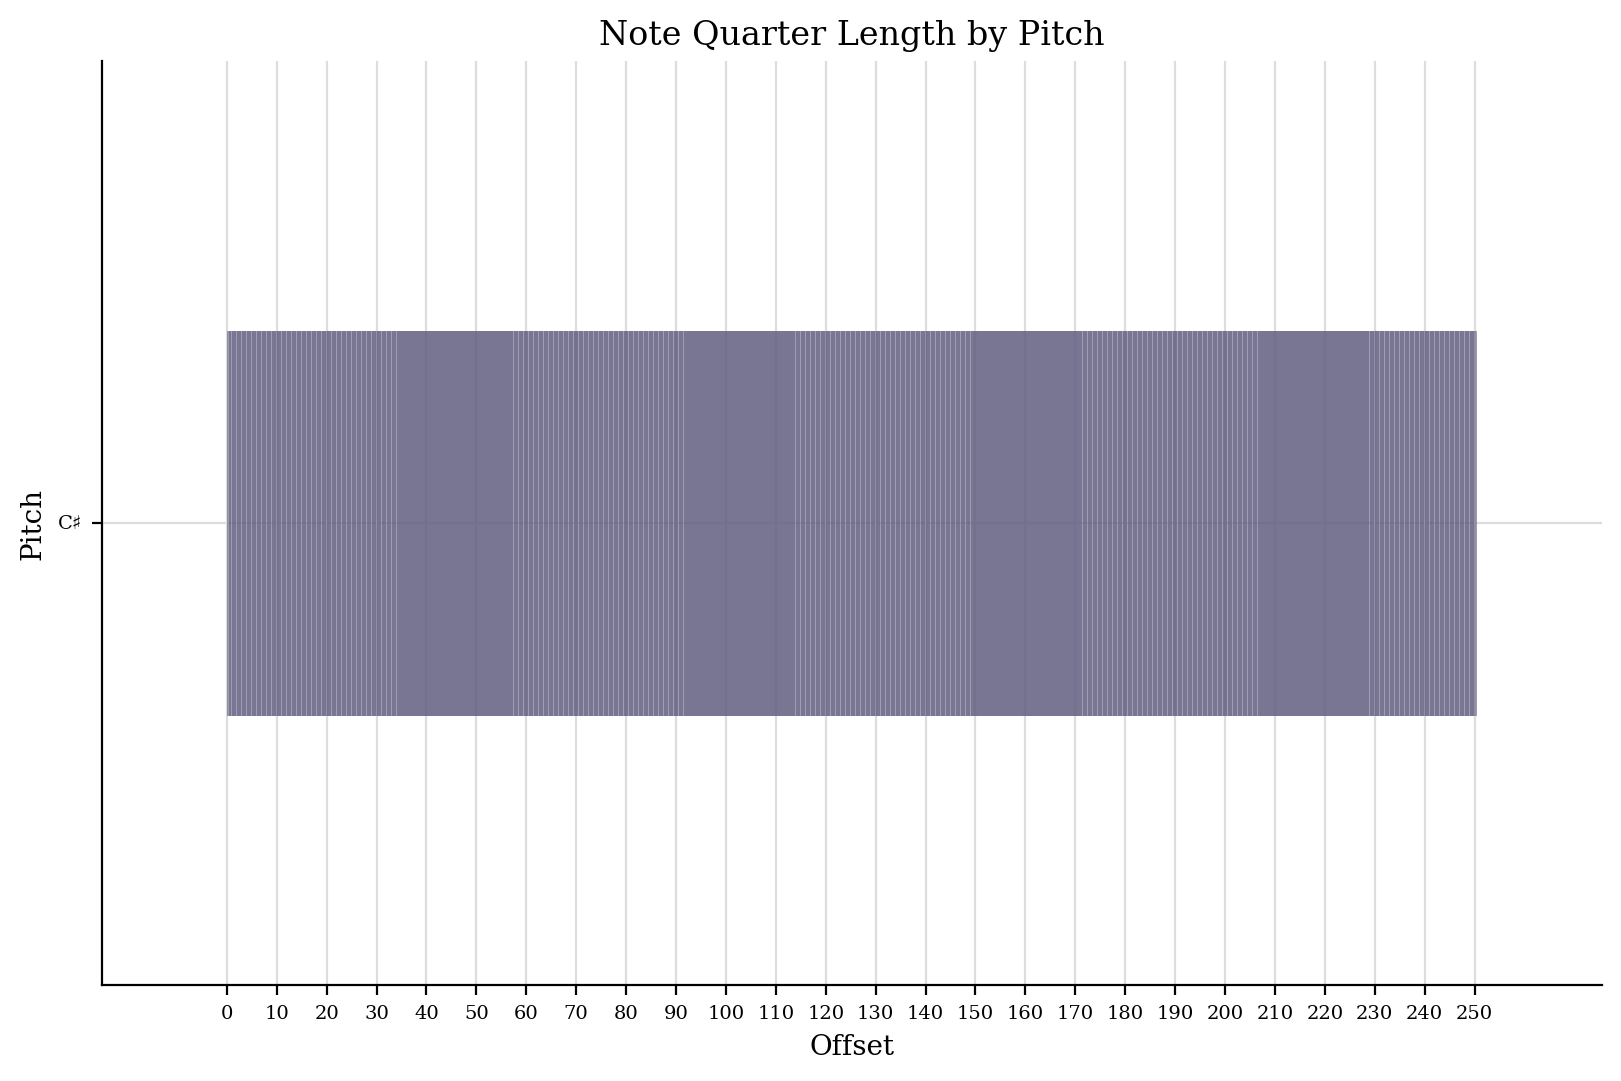

In [82]:
# Main function
if __name__ == '__main__':
    # Load and preprocess MIDI data
    notes = get_notes()
    sequence_length = 100
    sequence_input, sequence_output = prepare_sequences(notes, sequence_length)
    input_shape = (sequence_input.shape[1], sequence_input.shape[2])
    output_shape = sequence_output.shape[1]

    # Create and train the model
    model = create_model(input_shape, output_shape)
    train_model(model, sequence_input, sequence_output)

    # Generate seed notes for music generation
    random_index = np.random.randint(0, len(sequence_input)-1)
    seed_notes = sequence_input[random_index, :, :].flatten()

    # Generate music
    generated_notes = generate_music(model, sorted(set(notes)), sequence_length, seed_notes, num_notes=500)

    # Visualize and play generated music
    visualize_music(generated_notes)
